In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gzip
import random

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

In [2]:
# инициализируем генератор случайных чисел постоянным начальным значением для воспроизводимости результатов
seed = 7
np.random.seed(seed)

In [3]:
def extract_data(filename, num_images, IMAGE_WIDTH):
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(IMAGE_WIDTH * IMAGE_WIDTH * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, IMAGE_WIDTH*IMAGE_WIDTH)
        return data
    
    
def extract_labels(filename, num_images):
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [4]:
m = 20000
X = extract_data('train-images-idx3-ubyte.gz', m, 28)
Y = extract_labels('train-labels-idx1-ubyte.gz', m).reshape(m,1)

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz


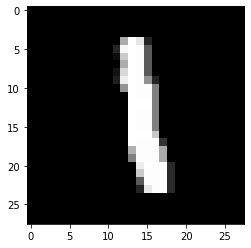

In [5]:
import matplotlib.cm as cm
plt.imshow(X[6].reshape((28, 28)), cmap=cm.Greys_r)
plt.show()

In [6]:
X = X.reshape(len(X), 28, 28)    
    
X_train = []
for i in range(len(X)):
    x_even = X[i]
    x_rand_1 = random.choice(X)
    x_rand_2 = random.choice(X)
    x_zeros = np.zeros((28, 28)).reshape((28, 28))
    
    prom = np.vstack((x_zeros, x_even))
    prom = np.vstack((prom, x_zeros))
    prom = prom.reshape((84, 28))
    
    rand_1 = np.vstack((x_zeros, x_rand_1))
    rand_1 = np.vstack((rand_1, x_zeros))
    rand_1 = rand_1.reshape((84, 28))
    
    rand_2 = np.vstack((x_zeros, x_rand_2))
    rand_2 = np.vstack((rand_2, x_zeros))
    rand_2 = rand_2.reshape((84, 28))
    
    x_train = np.column_stack((rand_1, prom))
    x_train = np.column_stack((rand_2, x_train))
    X_train.append(x_train)

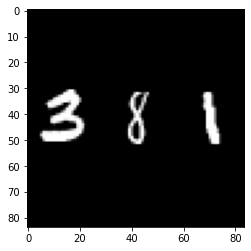

In [7]:
plt.imshow(X_train[6], cmap=cm.Greys_r)
plt.show()

In [8]:
X_train = np.asarray(X_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1).astype('float32')
# Обратный reshape
# X_train = X_train.reshape(X_train.shape[0], 84, 84).astype('float32')
X_train = X_train / 255

for i in Y:
    if i[0] % 2 == [0]:
        i[0] = 0  # число четное
    else:
        i[0] = 1  # число нечетное

In [9]:
# Тестовая выборка
_max = 10000
X_t = extract_data('t10k-images-idx3-ubyte.gz', _max, 28)
Y_test = extract_labels('t10k-labels-idx1-ubyte.gz', _max).reshape(_max,1)

X_t = X_t.reshape(len(X_t), 28, 28)

X_test = []
for i in range(len(X_t)):
    x_even = X_t[i]
    x_rand_1 = random.choice(X_t)
    x_rand_2 = random.choice(X_t)
    x_zeros = np.zeros((28, 28)).reshape((28, 28))
    
    prom = np.vstack((x_zeros, x_even))
    prom = np.vstack((prom, x_zeros))
    prom = prom.reshape((84, 28))
    
    rand_1 = np.vstack((x_zeros, x_rand_1))
    rand_1 = np.vstack((rand_1, x_zeros))
    rand_1 = rand_1.reshape((84, 28))
    
    rand_2 = np.vstack((x_zeros, x_rand_2))
    rand_2 = np.vstack((rand_2, x_zeros))
    rand_2 = rand_2.reshape((84, 28))
    
    x_test = np.column_stack((rand_1, prom))
    x_test = np.column_stack((rand_2, x_test))
    X_test.append(x_test)
    
X_test = np.asarray(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1).astype('float32')
X_test = X_test / 255

for i in Y_test:
    if i[0] % 2 == [0]:
        i[0] = 0  # число четное
    else:
        i[0] = 1  # число нечетное

Y = np_utils.to_categorical(Y)
Y_test = np_utils.to_categorical(Y_test)
num_classes = Y_test.shape[1]

Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz


In [10]:
def cnn_model():
    # Модель
    model = Sequential()
    model.add(Conv2D(32, (5, 5), input_shape=(84, 84, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
model = cnn_model()
# Fit the model
model.fit(X_train, Y, validation_data=(X_test, Y_test), epochs=10, batch_size=2000, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
10/10 - 52s - loss: 0.6031 - accuracy: 0.6866 - val_loss: 0.4663 - val_accuracy: 0.7816
Epoch 2/10
10/10 - 51s - loss: 0.4235 - accuracy: 0.8033 - val_loss: 0.3592 - val_accuracy: 0.8374
Epoch 3/10
10/10 - 52s - loss: 0.3729 - accuracy: 0.8316 - val_loss: 0.3262 - val_accuracy: 0.8659
Epoch 4/10
10/10 - 52s - loss: 0.3165 - accuracy: 0.8634 - val_loss: 0.2813 - val_accuracy: 0.8880
Epoch 5/10
10/10 - 51s - loss: 0.2786 - accuracy: 0.8817 - val_loss: 0.2287 - val_accuracy: 0.9069
Epoch 6/10
10/10 - 51s - loss: 0.2388 - accuracy: 0.9013 - val_loss: 0.1941 - val_accuracy: 0.9232
Epoch 7/10
10/10 - 51s - loss: 0.2034 - accuracy: 0.9204 - val_loss: 0.1648 - val_accuracy: 0.9366
Epoch 8/10
10/10 - 52s - loss: 0.1808 - accuracy: 0.9283 - val_loss: 0.1401 - val_accuracy: 0.9486
Epoch 9/10
10/10 - 53s - loss: 0.1620 - accuracy: 0.9383 - val_loss: 0.1235 - val_accuracy: 0.9557
Epoch 10/10
10/10 - 52s - loss: 0.1488 - accuracy: 0.9435 - val_loss: 0.1123 - val_accuracy: 0.9605
CNN Error